In [1]:
import sys
import time

from pishield.constraint_layer import build_pishield_layer
from pishield.propositional_constraints.constraints_layer import ConstraintsLayer
from torch.utils.data import DataLoader

from experiments.shapes import ShapeDataset

sys.path.append('..')

import torch
from torch import nn
import matplotlib.pyplot as plt
from experiments.plotting import plotting_experiment_results_net

from shapes import Rectangle
from experiment import Experiment

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

torch.manual_seed(2)

cpu


### Define the shapes

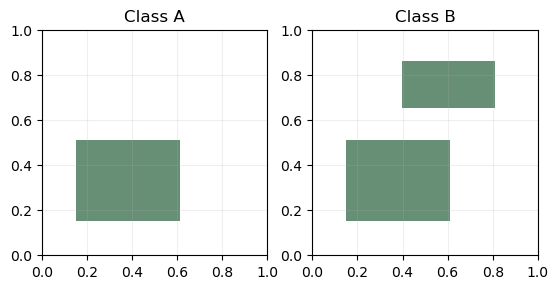

In [2]:
rectangle0 = Rectangle(0.15, 0.6, 0.15, 0.5)
rectangle1 = Rectangle(0.4, 0.8, 0.65, 0.85)
combined = rectangle0 | rectangle1
shapes = [rectangle0, combined]

fig, ax = plt.subplots(1, len(shapes))
ax[0].set_title("Class A")
ax[1].set_title("Class B")
ax[0].grid(alpha=0.2)
ax[1].grid(alpha=0.2)

for i, shape in enumerate(shapes):
  shape.plot(ax[i], full=True, cmap='Greens')
plt.show()

constraints_path = '../constraints/rectangles'

### Define the neural network

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self, shapes, points=2500, batch_size=2500, learning_rate=1e-1):
        super(NeuralNetwork, self).__init__()
        
        self.linear = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 2),
            nn.Sigmoid()
        )
        
        self.prepare_dataloaders(shapes, points, batch_size)
        self.optimizer = torch.optim.Adam(self.parameters(), lr = learning_rate, betas = (0.9, 0.999))
        self.loss_fn = nn.BCELoss()

    def prepare_dataloaders(self, shapes, points, batch_size):
        train_data = ShapeDataset(shapes, points)
        test_data = ShapeDataset(shapes, points)

        self.train_dataloader = DataLoader(train_data, batch_size=batch_size)
        self.test_dataloader = DataLoader(test_data, batch_size=batch_size)

    def forward(self, input):
        pred = self.linear(input)
        return pred
    
    def run(self, epochs):
        self.train()
        for epoch in range(epochs):
            for batch, (X, y) in enumerate(self.train_dataloader):
    
                # Compute prediction error
                pred = self(X, goal=y)
                loss = self.loss_fn(pred, y)
    
                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
    
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, loss: {loss.item():>7f} [{epoch:>5d}/{epochs:>5d}]")

    def save(self, dir='./models/'):
        path = f"{dir + 'rectangles'}-{int(time.time())}"
        torch.save(self, path + ".pth")
        print('Saved experiment at {path}'.format(path=path))
        

class PiShield_NeuralNetwork(NeuralNetwork):
    def __init__(self, shapes, constraints_path, points=2500, batch_size=2500, learning_rate=1e-1):
        super(PiShield_NeuralNetwork, self).__init__(shapes, points=points, batch_size=batch_size, learning_rate=learning_rate)
        self.clayer = build_pishield_layer(len(shapes), constraints_path, ordering_choice=None)
        
    def forward(self, input, goal=None):
        pred = self.linear(input)
        corrected_x = self.clayer(pred, goal=goal)
        return corrected_x
    
    def unconstrained_forward(self, input):
        return super().forward(input)


model = PiShield_NeuralNetwork(shapes, constraints_path)
print(model)

Using auto mode ::: Detected propositional constraints!
[] [<pishield.propositional_constraints.constraint.Constraint object at 0x7f261d31be50>]
head 1 with old rules 1
head 1 with new rules 1
Generated 1 strata of constraints with None centrality
PiShield_NeuralNetwork(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=2, bias=True)
    (3): Sigmoid()
  )
  (loss_fn): BCELoss()
  (clayer): ConstraintsLayer(
    (module_list): ModuleList(
      (0): ConstraintsModule()
    )
  )
)


### Train and test the model

In [ ]:
model.run(400)
model.save()
plotting_experiment_results_net(model, model.clayer, rectangle0, rectangle1)
plt.show()

Epoch 0, loss: 0.689555 [    0/  400]
Epoch 100, loss: 0.224294 [  100/  400]
Epoch 200, loss: 0.110360 [  200/  400]
Epoch 300, loss: 0.082923 [  300/  400]
Saved experiment at ./models/rectangles-1707180702


In [ ]:
# Probably it would be good to have a "violations counter" (just to show that there are indeed no violations)
# And maybe see when you are creating the video, but it might be good to split the top row from the bottom row
# Also, I think you can train the network in real time, I tried with 20 neurons and 400 epochs and it trains almost instantly  

In [ ]:
model = torch.load('./models/rectangles-1707179045.pth')  # model trained for 5000 epochs
plotting_experiment_results_net(model, model.clayer, rectangle0, rectangle1)
plt.show()